### Open and read a wavefile, then write contents to output file
This is a proof of concept for reading/writing wave files, and will likely form the outer shell of the code later

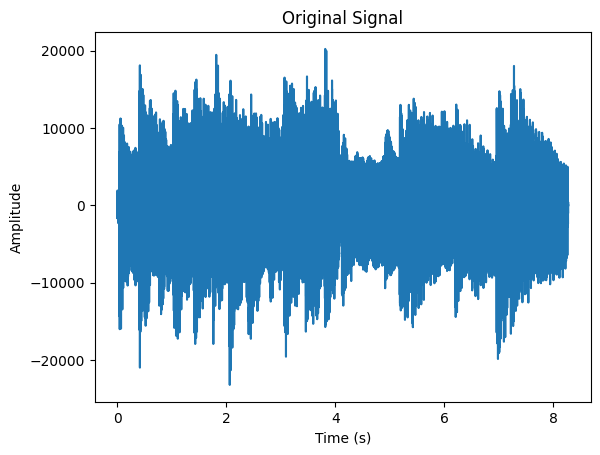

In [55]:
import wave
import numpy as np
import matplotlib.pyplot as plt

input_file_path = './electric_guitar_sample.wav'

def load_audio(file_path):
    audio_data = wave.open(file_path, 'r')
    return audio_data

def convert_to_numpy_array(signal):
    frame_count = signal.getnframes()
    audio_frames = signal.readframes(frame_count)
    audio_frames = np.frombuffer(audio_frames, dtype = np.int16)
    return audio_frames

def write_to_wav_file(file_path, audio_frames, channel_count, sample_width, sample_rate):
    with wave.open(file_path, 'w') as output_file:
        output_file.setnchannels(channel_count)
        output_file.setsampwidth(sample_width)
        output_file.setframerate(sample_rate)
        output_file.writeframes(audio_frames)

def plot_audio_data(array, signal_framerate, title):
    time = np.linspace(0, len(array) / signal_framerate, num = len(array))
    
    plt.figure()
    plt.plot(time, array)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(title)
    plt.show()

audio_data = load_audio(input_file_path)
audio_frames = convert_to_numpy_array(audio_data)

channel_count = audio_data.getnchannels()
sample_width = audio_data.getsampwidth()
sample_rate = 44100
frame_rate = audio_data.getframerate() * 2

plot_audio_data(audio_frames, frame_rate, 'Original Signal')

output_file_path = './outputs/unaltered_output.wav'
write_to_wav_file(output_file_path, audio_frames, channel_count, sample_width, sample_rate)

#### Test Signal

In [ ]:
from numpy import cos, sin, pi, arange

sample_rate = 20000
nsamples = 400
t = arange(nsamples) / sample_rate
x = cos(2*pi*40*t) + 0.2*sin(2*pi*500*t+0.1) + \
        0.2*sin(2*pi*1500*t) + 0.1*sin(2*pi*5000*t + 0.1) + \
            0.1*sin(2*pi*10000*t+.8)

#### Filters

In [70]:
# 3 band equalizer:
# bass: 1Hz - 800Hz
# mid: 800Hz - 3000Hz
# treble: 3000Hz - 8000Hz

from numpy import cos, sin, pi, absolute, arange, convolve
from scipy.signal import kaiserord, lfilter, firwin, freqz, filtfilt
from pylab import figure, clf, plot, xlabel, ylabel, xlim, ylim, title, grid, axes, show
from scipy.io import wavfile

# Create a FIR filter and apply it to x

nyquist_rate = sample_rate / 2.0
transition_width = 5000 / nyquist_rate

stop_band_attenuation_dB = 60
low_transition_freq = 800
high_transition_freq = 3000

FIR_order, beta = kaiserord(stop_band_attenuation_dB, transition_width)

lowpass_filter = firwin(FIR_order, low_transition_freq, window=('kaiser', beta), fs = sample_rate)
bandpass_filter = firwin(FIR_order, [low_transition_freq / nyquist_rate, high_transition_freq / nyquist_rate], pass_zero=False)
highpass_filter = firwin(FIR_order, high_transition_freq / nyquist_rate, pass_zero=False)

low_freq_signal = lfilter(lowpass_filter, 1.0, x=audio_frames)
mid_freq_signal = lfilter(bandpass_filter, 1.0, audio_frames)
high_freq_signal = lfilter(highpass_filter, 1.0, audio_frames)
low_freq_signal_2 = np.convolve(audio_frames, lowpass_filter, mode='same')

print(len(low_freq_signal))

figure()
w, h = freqz(lowpass_filter, worN=8000)
plot((w/pi)*nyquist_rate, absolute(h), linewidth=2)
w, h = freqz(bandpass_filter, worN=8000)
plot((w/pi)*nyquist_rate, absolute(h), linewidth=2)
w, h = freqz(highpass_filter, worN=8000)
plot((w/pi)*nyquist_rate, absolute(h), linewidth=2)
title('Filter Curves for 3 Bands')
grid(True)

figure()
plot(lowpass_filter, linewidth=2)
plot(bandpass_filter, linewidth=2)
plot(highpass_filter, linewidth=2)
title('Filter Coefficients (%d coefficients)' % FIR_order)
grid(True)

plot_audio_data(low_freq_signal, frame_rate, 'Audio Signal After Low Pass Filtering')
plot_audio_data(mid_freq_signal, frame_rate, 'Audio Signal After Bandpass Filtering')
plot_audio_data(high_freq_signal, frame_rate, 'Audio Signal After High Pass Filtering')

output_file_path = './outputs/test2.wav'
write_to_wav_file(output_file_path, low_freq_signal, channel_count, sample_width, sample_rate)
wavfile.write('outputs/lowfreq.wav', frame_rate, low_freq_signal)
wavfile.write('outputs/midfreq.wav', frame_rate, mid_freq_signal)
wavfile.write('outputs/highfreq.wav', frame_rate, high_freq_signal)
wavfile.write('outputs/original.wav', frame_rate, audio_frames)

TypeError: lfilter() missing 1 required positional argument: 'a'

#### FFT Implementation for Audio Signal

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import wave

def open_plot_file():

    file_path = './outputs/test.wav'

    audio_data = wave.open(file_path, 'r')

    audio_signal = audio_data.readframes(-1)
    audio_signal = np.frombuffer(audio_signal, dtype='int16')
    
    print(audio_signal)

    plt.figure(1)
    plt.plot(audio_signal)

    audio_fft = np.fft.fft(audio_signal)
    audio_freq = np.fft.fftfreq(len(audio_signal))
    
    print(audio_fft)
    
    plt.figure(2)
    plt.plot(audio_fft)
    
    Y    = np.fft.fft(audio_signal)
    freq = np.fft.fftfreq(len(audio_signal))

    plt.figure()
    plt.plot( freq, np.abs(Y) )
    plt.figure()
    plt.plot(freq, np.angle(Y) )
    plt.show()

open_plot_file()

#### Other Method to Plot FFT of Signal

In [ ]:
import numpy as np
import wave
import matplotlib.pyplot as plt
import os

def perform_fft(signal, sample_rate):
    # perform the FFT
    fft = np.fft.fft(signal)
    # calculate the frequency bins
    frequency_bins = np.fft.fftfreq(len(signal), 1 / sample_rate)
    return fft, frequency_bins

files = ['electric_guitar_sample.wav', './outputs/test.wav']
files_set = set(files)
#create subplots
fig, files_set = plt.subplots(len(files))

# Open wave file
# iterate through files in audio_samples
for i, file  in enumerate(files):
    wav_file = wave.open('./' + file, 'r')

    # Extract Raw Audio from Wav File
    signal = wav_file.readframes(-1)
    frame_rate = wav_file.getframerate()
    signal = np.frombuffer(signal, dtype='int16')

    fft_out, frequency_bins = perform_fft(signal, frame_rate)

    #plot the fft
    plt.plot(frequency_bins, fft_out)

    plt.xlabel('Frequency')
    plt.ylabel('Amplitude')

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, hspace=0.5, wspace=0.5)
#show all the plots
plt.show()

### References
1. https://stackoverflow.com/questions/24920346/filtering-a-wav-file-using-python
2. https://octovoid.com/2017/11/04/coding-a-parametric-equalizer-for-audio-applications/
3. https://stackoverflow.com/questions/54932976/audio-equalizer
4. https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html
5. https://scipy-cookbook.readthedocs.io/items/FIRFilter.html
6. https://www.controlpaths.com/2021/06/28/audio-equalizer-based-on-fir-filters/